In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import scvelo as scv
import seaborn as sb
from anndata.experimental.pytorch import AnnLoader

In [2]:
# get data
adata = scv.datasets.gastrulation()
print(adata.shape)

(89267, 53801)


## 1. Quality Control (filter data)

In [3]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
print(adata.obs['n_counts'])
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
print(adata.obs['log_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
print(adata.obs['n_genes'])

index
cell_1          6844.0
cell_2         14712.0
cell_6         15273.0
cell_8         16898.0
cell_9         18510.0
                ...   
cell_139326    19663.0
cell_139327    13046.0
cell_139329    14753.0
cell_139330    22383.0
cell_139331    13071.0
Name: n_counts, Length: 89267, dtype: float32
index
cell_1          8.831128
cell_2          9.596418
cell_6          9.633842
cell_8          9.734951
cell_9          9.826066
                 ...    
cell_139326     9.886494
cell_139327     9.476237
cell_139329     9.599202
cell_139330    10.016057
cell_139331     9.478151
Name: log_counts, Length: 89267, dtype: float32
index
cell_1         2218
cell_2         3279
cell_6         3445
cell_8         3567
cell_9         3848
               ... 
cell_139326    3134
cell_139327    2627
cell_139329    3470
cell_139330    3333
cell_139331    3351
Name: n_genes, Length: 89267, dtype: int64


In [4]:
# Calculate quantiles for number of counts
n_counts = pd.Series(adata.obs['n_counts'])
count_quantiles = n_counts.quantile([0.05, 0.95])
print(count_quantiles)

0.05     5379.0
0.95    19918.0
Name: n_counts, dtype: float64


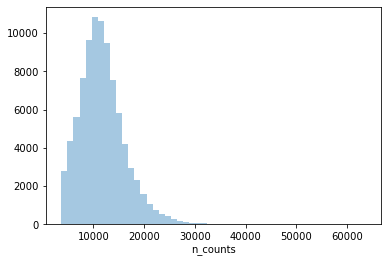

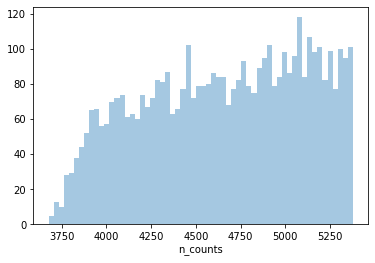

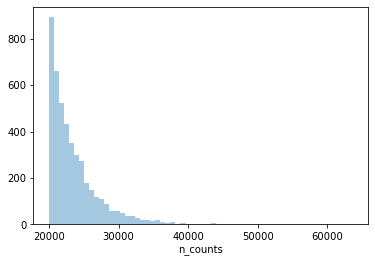

In [5]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts'] < count_quantiles.iloc[0]], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts'] > count_quantiles.iloc[1]], kde=False, bins=60)
plt.show()

In [6]:
# Calculate quantiles for number of genes
n_genes = pd.Series(adata.obs['n_genes'])
gene_quantiles = n_genes.quantile([0.05, 0.95])
print(gene_quantiles)

0.05    1987.0
0.95    3937.0
Name: n_genes, dtype: float64


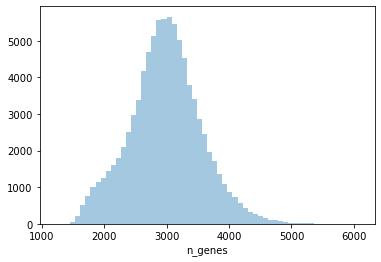

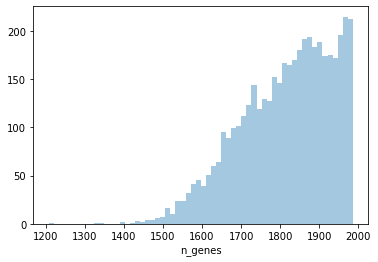

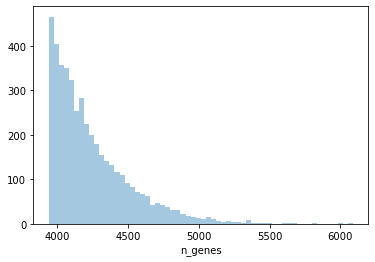

In [7]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes'] < gene_quantiles.iloc[0]], kde=False, bins=60)
plt.show()

p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes'] > gene_quantiles.iloc[1]], kde=False, bins=60)
plt.show()

In [8]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = count_quantiles.iloc[0])
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = count_quantiles.iloc[1])
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = gene_quantiles.iloc[0])
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_genes = gene_quantiles.iloc[1])
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 89267
Number of cells after min count filter: 84804
Number of cells after max count filter: 80342
Number of cells after gene filter: 79648
Number of cells after gene filter: 78602


In [9]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 53801
Number of genes after cell filter: 19701


## 2. Normalization

In [10]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000,)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata_pp)
print(adata.shape)

(78602, 19701)


In [11]:
adata = adata[:,adata.var['highly_variable']].copy()

In [12]:
time_steps = ["E6.5", "E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]
[adata[adata.obs["stage"] == time].shape for time in time_steps]

[(2008, 2000),
 (1162, 2000),
 (9344, 2000),
 (9944, 2000),
 (6388, 2000),
 (8917, 2000),
 (13493, 2000),
 (13184, 2000),
 (14162, 2000)]

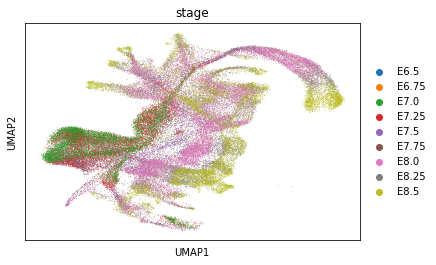

In [13]:
sc.pl.umap(adata, color="stage")

In [15]:
for time in time_steps:
    episode_adata = adata[adata.obs["stage"] == time].copy()
    episode_adata.write(f"../neural_ot/data/Gastrulation/gastrulation_{time}.h5ad")

In [10]:
e825_adata = sc.read(f"../neural_ot/data/Gastrulation/gastrulation_E825.h5ad")
e850_adata = sc.read(f"../neural_ot/data/Gastrulation/gastrulation_E850.h5ad")

In [89]:
from torch.utils.data import DataLoader


source_dataloader = iter(AnnLoader(e825_adata, batch_size=1024,))
target_dataloader = AnnLoader(e850_adata, batch_size=1024)

In [86]:
source_dataloader = DataLoader(e825_adata, batch_size=1024,)

In [90]:
next(source_dataloader)

AnnCollectionView object with n_obs × n_vars = 1024 × 2000
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'spliced', 'unspliced'
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'n_counts', 'log_counts', 'n_genes'

In [126]:
from torch.utils.data import Dataset

class AnnDataset(Dataset):

    def __init__(
        self,
        adata
    ):
        super().__init__()
        self.adata = adata

    def __getitem__(self, index):
        print(type(self.adata[index].X.toarray()))
        return self.adata[index].X.toarray()

    def __len__(self):
        """
        :return: length of the dataset
        """
        return len(self.adata)

In [127]:
source_dataloader = iter(DataLoader(AnnDataset(e825_adata), batch_size=1024))
target_dataloader = iter(DataLoader(AnnDataset(e850_adata), batch_size=2))

In [128]:
print(next(target_dataloader))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
tensor([[[0.0000, 0.0000, 0.0000,  ..., 5.6083, 0.0000, 1.6024]],

        [[0.0000, 0.0000, 0.0000,  ..., 8.8262, 3.2095, 0.8024]]])
